# Customer Segmentation

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 150)

import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download datasets 
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

In [ ]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

In [4]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [5]:
order_products.user_id.nunique()

206209

## Segmentation

Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [6]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [7]:
#Normalization
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.050847,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033898,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084746,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.152542,0.000000,0.000000,0.0,0.000000,0.135593,0.0,0.000000,0.0,0.0,0.000000,0.033898,0.0,0.000000,0.000000,0.203390,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220339,0.000000,0.033898,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,0.0,0.005128,0.005128,0.010256,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005128,0.0,0.000000,0.061538,0.0,0.0,0.0,0.0,0.025641,0.0,0.056410,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.030769,0.0,0.0,0.0,0.0,0.0,0.0,0.046154,0.169231,0.000000,0.000000,0.000000,0.0,0.005128,0.000000,0.0,0.0,0.061538,0.0,0.0,0.0,0.020513,0.0,0.0,0.005128,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.005128,0.0,0.0,0.0,0.0,0.051282,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.015385,0.000000,0.005128,0.0,0.000000,0.025641,0.0,0.005128,0.0,0.0,0.015385,0.000000,0.0,0.005128,0.000000,0.051282,0.0,0.000000,0.005128,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005128,0.0,0.000000,0.0,0.0,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.

## PCA and K-Means Clustering
Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension.

In [8]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018866,-0.088345,-0.104522,-0.116442,0.083762,-0.061818,-0.026439
1,-0.036988,0.108884,-0.066406,-0.123270,0.098847,-0.033960,-0.054737,-0.053366,-0.020401,-0.008021
2,0.064282,0.103962,0.000710,-0.012220,-0.046991,0.112246,-0.029808,0.007890,0.012237,0.002094
3,-0.093210,0.054093,0.001867,-0.003974,-0.071352,-0.019291,-0.025118,-0.038268,0.006091,-0.000526
4,0.094629,-0.037051,-0.024952,-0.021575,0.055368,0.107650,-0.008031,0.103929,0.051635,-0.025721


In [9]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

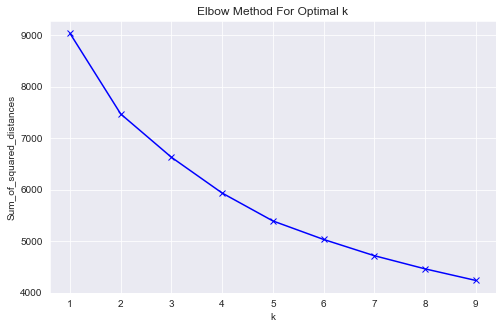

In [10]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**From above plot we choose optimal K as 5**

In [11]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[ 6.75073584e-02  1.05718985e-01 -1.14233803e-03 -3.09298101e-02
  -1.07023114e-02  7.22177107e-03 -5.20930608e-04  4.51774302e-03
  -7.22820784e-04 -1.62299057e-04]
 [-1.98201878e-01  1.61379567e-02  3.16916631e-01 -3.13693157e-02
   1.86338969e-02  5.64631803e-04  4.00983292e-03  1.09267428e-02
   1.24328674e-03 -3.84948971e-03]
 [-7.39220810e-02 -1.06013694e-02 -2.70272731e-02 -6.98748654e-03
  -6.75957954e-03  1.54267359e-03  5.07322390e-04 -2.53841430e-03
  -3.27771337e-04 -4.05973845e-04]
 [ 1.05576711e-01 -7.31240628e-02  1.72645910e-02  3.68233856e-03
   1.77181746e-03 -4.44674714e-03 -9.47746548e-04  1.29287854e-03
  -1.60110954e-04  7.71200141e-04]
 [-6.11321742e-03  1.30752040e-01  4.86015633e-03  2.30189934e-01
   1.10170906e-01 -2.28272688e-02  7.50116725e-05 -6.42379245e-03
   7.81038216e-03  3.04927007e-03]]


### Visualizing clustering among first two principal components

In [12]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

,pc1,pc2,cluster
0,-0.113443,0.039084,2
1,-0.036988,0.108884,0
2,0.064282,0.103962,0
3,-0.093210,0.054093,2
4,0.094629,-0.037051,3


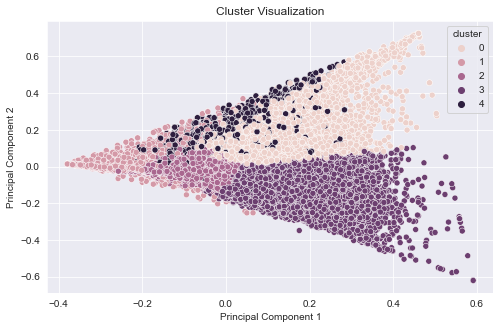

In [13]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [14]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

### Top products per cluster

In [15]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.758444
fresh vegetables                 15.046117
packaged vegetables fruits       12.103889
yogurt                            9.895531
milk                              5.961556
packaged cheese                   5.115307
soy lactosefree                   3.779908
water seltzer sparkling water     3.613131
bread                             3.198392
chips pretzels                    3.134687
dtype: float64

In [16]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.946834
fresh fruits                      3.335979
soft drinks                       2.803397
yogurt                            2.255307
energy granola bars               1.556766
chips pretzels                    1.346686
tea                               1.329887
milk                              1.326749
packaged vegetables fruits        1.251061
soy lactosefree                   1.082518
dtype: float64

In [17]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.767164
fresh vegetables                 7.571506
yogurt                           7.217632
packaged vegetables fruits       5.999556
packaged cheese                  4.931334
chips pretzels                   4.480795
milk                             4.252722
water seltzer sparkling water    4.091195
refrigerated                     3.257504
ice cream ice                    3.097864
dtype: float64

In [18]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.043744
fresh fruits                     21.745314
packaged vegetables fruits       12.027114
yogurt                            6.159564
packaged cheese                   5.018942
fresh herbs                       4.151554
milk                              4.003046
soy lactosefree                   3.704831
frozen produce                    3.302032
water seltzer sparkling water     3.080571
dtype: float64

In [19]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.354051
fresh fruits                     10.877453
packaged vegetables fruits        4.240186
fresh vegetables                  3.105813
water seltzer sparkling water     1.714519
milk                              1.615627
packaged cheese                   1.544162
frozen produce                    1.144942
chips pretzels                    1.139155
nuts seeds dried fruit            1.033090
dtype: float64

### Customer Segmentation Results:

* Cluster 1 results into 5428 consumers having a very strong preference for water seltzer sparkling water aisle.
* Cluster 2 results into 55784 consumers who mostly order fresh vegetables followed by fruits.
* Cluster 3 results into 7948 consumers who buy packaged produce and fresh fruits mostly.
* Cluster 4 results into 37949 consumers who have a very strong preference for fruits followed by fresh vegetables.
* Cluster 5 results into 99100 consumers who orders products from many aisles. Their mean orders are low compared to other
* clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet.